In [2]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score,mean_absolute_error,mean_squared_error
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.stats import pearsonr, reciprocal, uniform
from sklearn.tree import export_graphviz
from sklearn import preprocessing
from io import StringIO  
from IPython.display import Image
import pydotplus
from scipy import stats
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LogisticRegression

In [3]:
# Reading the Data
df = pd.read_excel('data/CRT_data_scrubbed.xlsx',sheet_name='chatanalysisdata')
df.head()

owner first_response_at_localtime_upd opened_at_localtime_c  \
0  owner1             2020-08-11 07:33:00   2020-08-11 07:23:00   
1  owner1             2020-08-11 07:47:00   2020-08-11 07:42:00   
2  owner1             2020-08-11 08:02:00   2020-08-11 07:59:00   
3  owner1             2020-08-11 09:51:00   2020-08-11 09:50:00   
4  owner1             2020-08-11 10:00:00   2020-08-11 09:57:00   

  claimed_at_localtime_c REPORT DATE       id     requester State  WEEK DAY  \
0    2020-08-11 07:33:00  2020-08-11  2504553   requester79   VIC         3   
1    2020-08-11 07:46:00  2020-08-11  2504647   requester74   VIC         3   
2    2020-08-11 07:59:00  2020-08-11  2504729   requester37   VIC         3   
3    2020-08-11 09:51:00  2020-08-11  2505299  requester102   VIC         3   
4    2020-08-11 09:59:00  2020-08-11  2505336  requester119   VIC         3   

  REPORT DAY  ... Chat before Chat for first time in day, never chat before  \
0    Tuesday  ...           0                                             1   
1    Tuesday  ...           0                                             1   
2    Tuesday  ...           0                                             1   
3    Tuesday  ...           0                                             1   
4    Tuesday  ...           1                                             0   

   Chat for first time in day, chat before  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   Subsequent chat in day, never chat before  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   Subsequent chat in day, chat before  \
0                                    0   
1                                    0   
2                                    0   
3                                    0   
4                                    1   

   Total duration of chat with tech before  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      3.7   

   Duration since last chat with technician  Response Times ADJ  Outlier ADJ  \
0                                       NaN             10.0833            1   
1                                       NaN              5.7833            1   
2                                       NaN              2.9833            0   
3                                       NaN              1.2166            0   
4                                150.016667              2.5166            0   

   Outlier  
0        0  
1        0  
2        0  
3        0  
4        0  

[5 rows x 70 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906 entries, 0 to 2905
Data columns (total 70 columns):
 #   Column                                            Non-Null Count  Dtype         
---  ------                                            --------------  -----         
 0   owner                                             2906 non-null   object        
 1   first_response_at_localtime_upd                   2906 non-null   datetime64[ns]
 2   opened_at_localtime_c                             2906 non-null   datetime64[ns]
 3   claimed_at_localtime_c                            2906 non-null   datetime64[ns]
 4   REPORT DATE                                       2906 non-null   datetime64[ns]
 5   id                                                2906 non-null   int64         
 6   requester                                         2906 non-null   object        
 7   State                                             2906 non-null   object        
 8   WEEK DAY                    

In [5]:
# Preparing Numerical Features / Categorical Features / Labels
label_cols = ['Sum of SLA Pass','Average of response_time_in_minutes','Average of claim_time_in_minutes']

columns_to_drop = ['Outlier Technician (20)','Outlier Technician (10)','id','WEEK DAY','Response Times ADJ','Outlier ADJ', 'Outlier','Chat Duration','Time of day of chat', 'Time of day of chat (3 way)','Entire Chat Overlap?','Duration since last chat with technician','Sum of message_count','Sum of avg_message_count_in_exchange','Sum of exchange_count','Chat Duration','Average of claim_time_in_minutes','Average of interaction_time_in_minutes','Average of resolution_time_in_minutes','Average of handle_time_in_minutes']
num_feature_cols = list(df.select_dtypes(include=np.number).columns.drop(label_cols+columns_to_drop))

cat_feature_cols = ['State','REPORT DAY','HOUR','owner','requester']

num_feature_cols_label = num_feature_cols + label_cols

# Exploratory Data Analysis

In [6]:
# Target Class distribution
df[label_cols].describe()

Sum of SLA Pass  Average of response_time_in_minutes  \
count      2906.000000                          2820.000000   
mean          0.670681                             6.311468   
std           0.470047                            44.124797   
min           0.000000                             0.100000   
25%           0.000000                             0.845825   
50%           1.000000                             1.950000   
75%           1.000000                             3.866600   
max           1.000000                          1244.433300   

       Average of claim_time_in_minutes  
count                       2906.000000  
mean                           4.357794  
std                           27.934714  
min                            0.016600  
25%                            0.333300  
50%                            1.433300  
75%                            3.000000  
max                          748.200000

In [7]:
# Class distribution of met/miss SLA
df['Sum of SLA Pass'].value_counts()

1    1949
0     957
Name: Sum of SLA Pass, dtype: int64

In [8]:
# Categorical columns
df[cat_feature_cols].describe()

State REPORT DAY  HOUR   owner    requester
count   2906       2906  2906    2906         2906
unique     6          5    19      17          167
top       SA     Monday  3 PM  owner4  requester49
freq     811        684   394     517           80

In [9]:
# Numerical columns
df[num_feature_cols].describe()

Gap between chat initiation  Last Chat Duration  Partial Chat Overlap?  \
count                  2906.000000         2906.000000            2906.000000   
mean                     36.612990           84.402191               0.323469   
std                      66.262852         1223.607458               0.467880   
min                       0.016667           -0.583333               0.000000   
25%                       6.387500            0.400000               0.000000   
50%                      18.275000            6.933333               0.000000   
75%                      43.133333           20.345833               1.000000   
max                    1260.450000        40862.000000               1.000000   

       Duration of break before chat  Break before chat?  \
count                    2906.000000         2906.000000   
mean                       35.349584            0.676531   
std                        79.202878            0.467880   
min                         0.000000            0.000000   
25%                         0.000000            0.000000   
50%                         7.587500            1.000000   
75%                        39.200000            1.000000   
max                      1216.750000            1.000000   

       Overlap time with previous chat  Num ongoing chats before response  \
count                      2906.000000                        2906.000000   
mean                         19.596060                           0.428768   
std                         721.264621                           0.926146   
min                          -0.583333                           0.000000   
25%                           0.000000                           0.000000   
50%                           0.000000                           0.000000   
75%                           2.091667                           1.000000   
max                       38810.133330                           8.000000   

       Previous chat claim_time_in_minutes  \
count                          2906.000000   
mean                              3.917728   
std                              17.067628   
min                               0.016600   
25%                               0.366600   
50%                               1.483300   
75%                               3.083300   
max                             681.066600   

       Previous chat response_time_in_minutes  \
count                             2906.000000   
mean                                 6.060113   
std                                 37.276326   
min                                  0.000000   
25%                                  0.883300   
50%                                  2.116600   
75%                                  4.481212   
max                               1867.749900   

       Previous chat interaction_time_in_minutes  ...  \
count                                2906.000000  ...   
mean                                   89.878160  ...   
std                                  1224.187195  ...   
min                                     0.033300  ...   
25%                                     3.920775  ...   
50%                                    11.400000  ...   
75%                                    25.704100  ...   
max                                 40866.966600  ...   

       time_since_requesters_last_request_mins  Chat for first time in day  \
count                              2906.000000                 2906.000000   
mean                               2161.856868                    0.462836   
std                                4562.539565                    0.498703   
min                                   0.000000                    0.000000   
25%                                  71.201779                    0.000000   
50%                                 453.374600                    0.000000   
75%                                2074.929425                    1.000000   
max                               80752.571350 

In [10]:
# Columns with missing values
cols_with_missing = df.columns[df.isna().any()].tolist()
df[cols_with_missing].isna().sum()   

Average of response_time_in_minutes           86
Average of resolution_time_in_minutes         44
Entire Chat Overlap?                          37
Time of day of chat                           69
Time of day of chat (3 way)                   69
Duration since last chat with technician    2407
dtype: int64

In [11]:
# checking for duplicate rows and removing
display(df.duplicated().sum())
df.drop_duplicates(inplace=True)

0

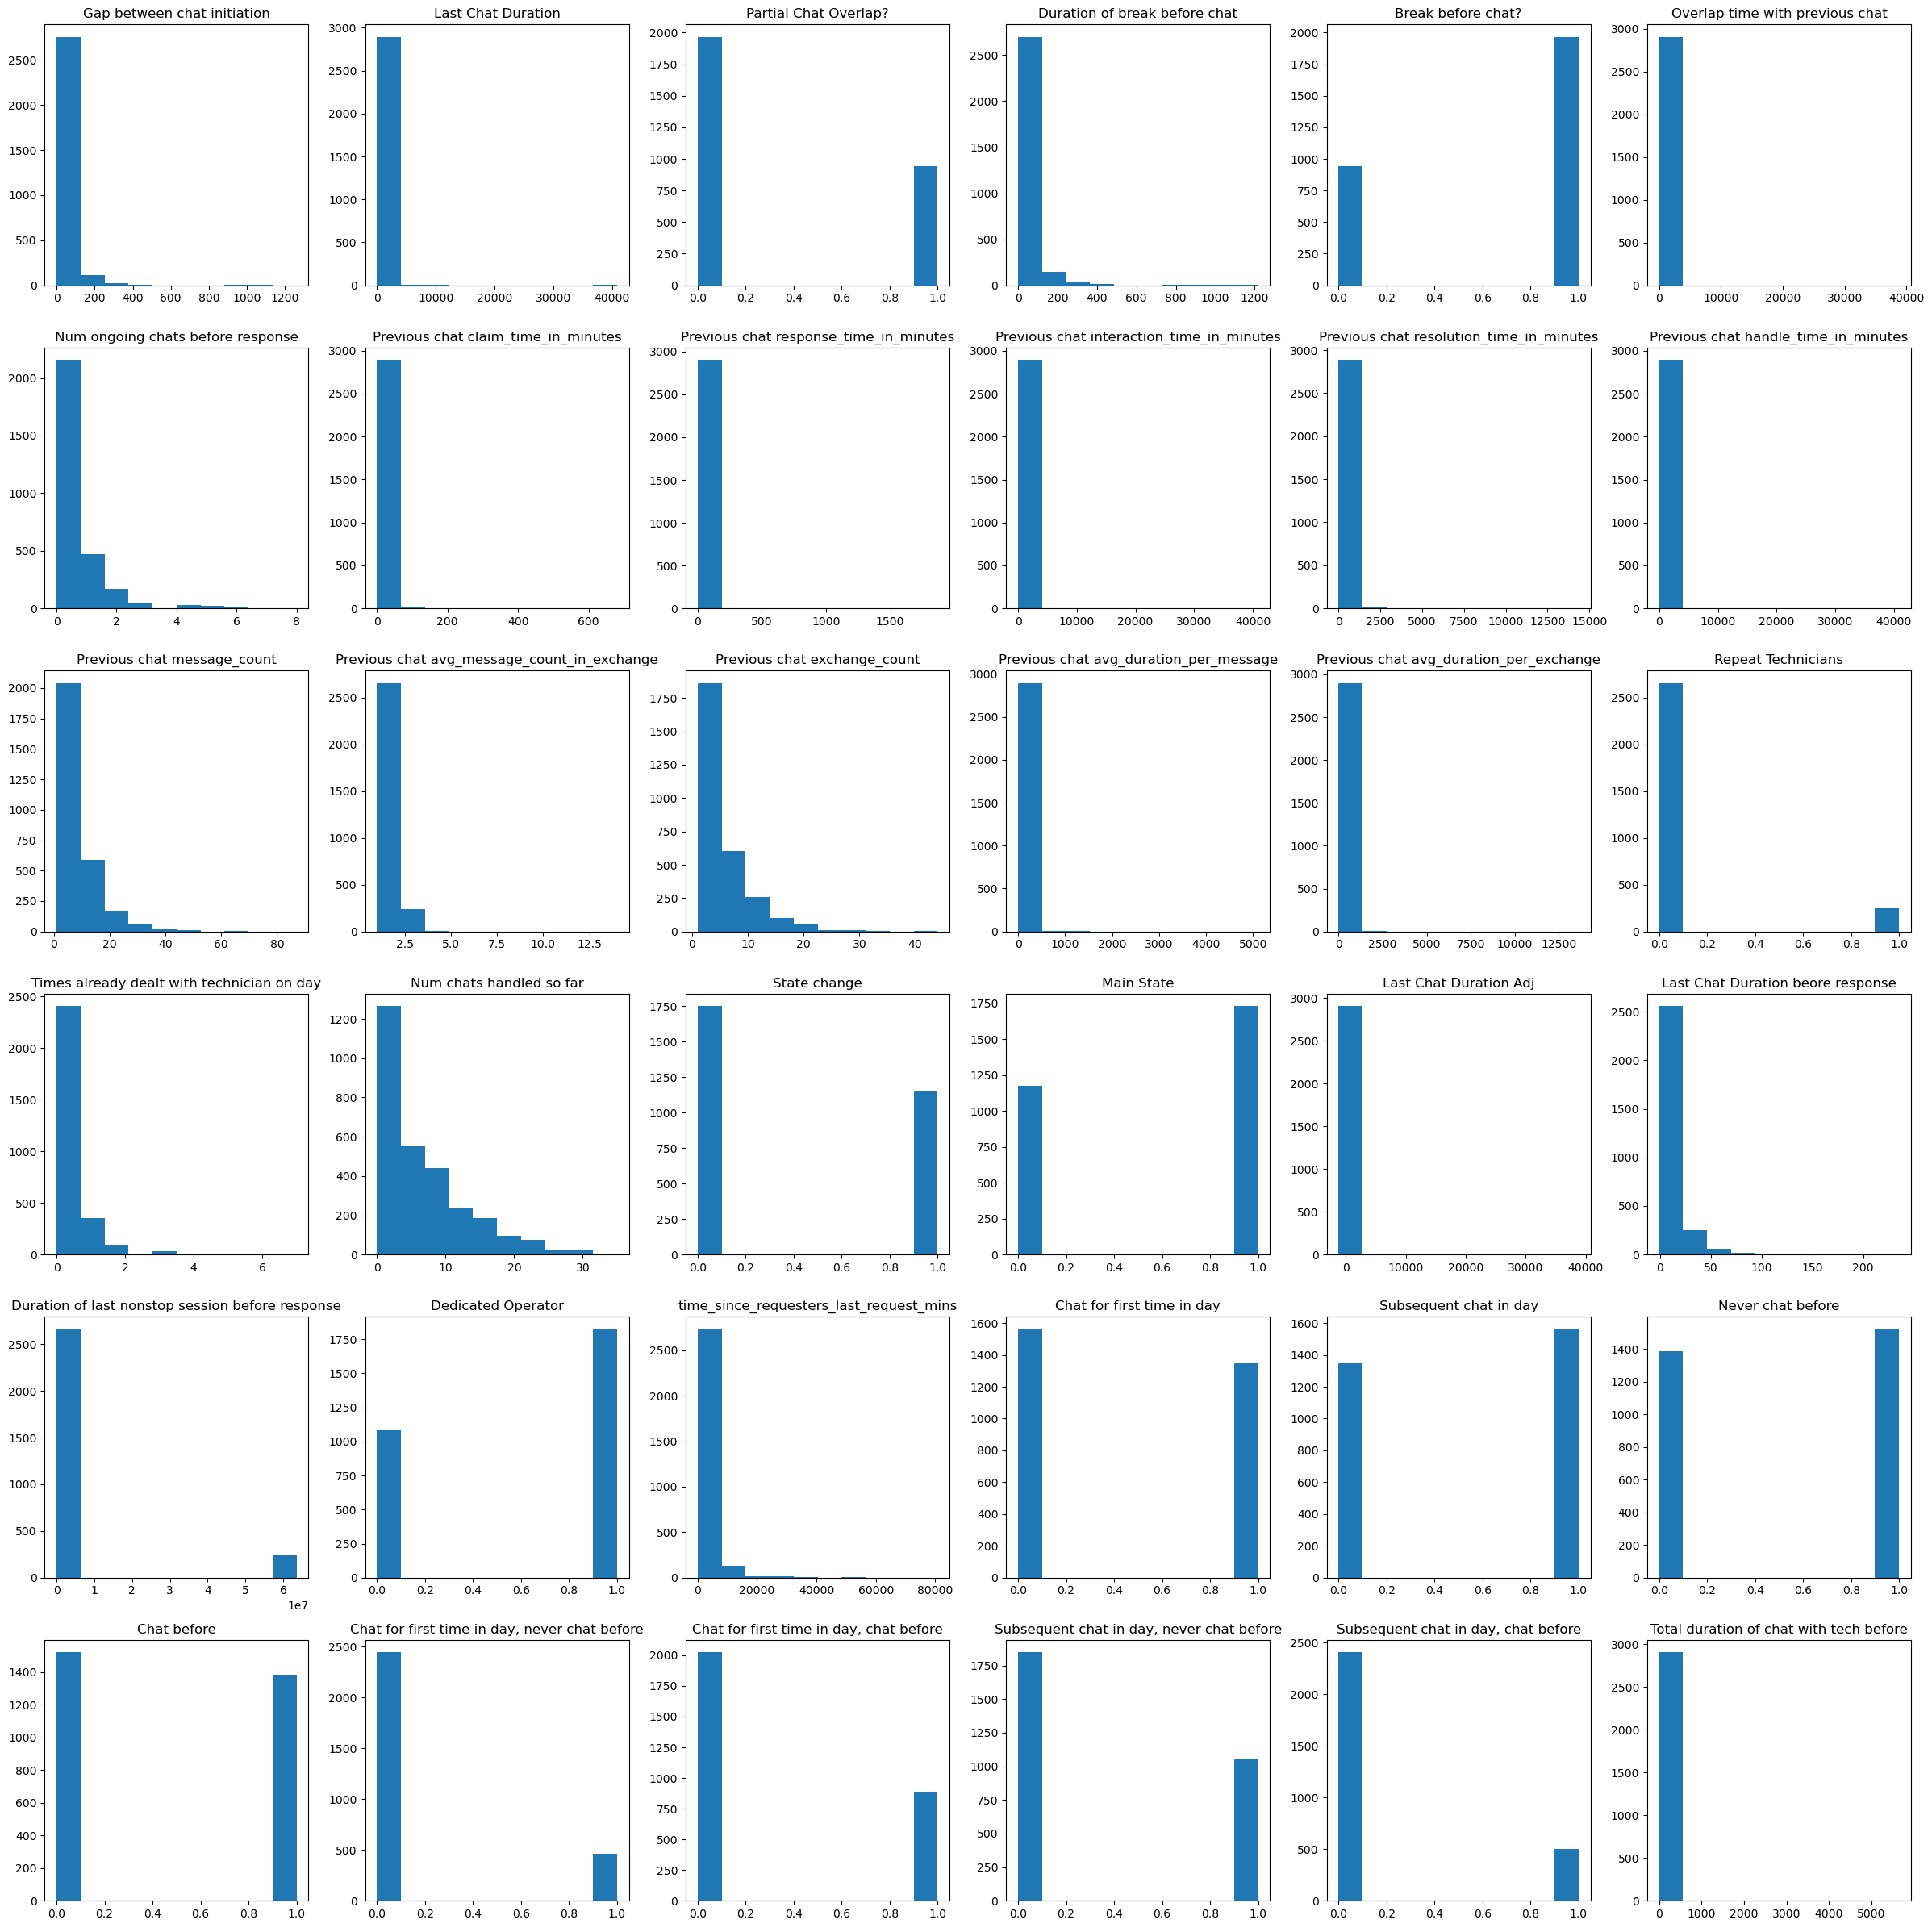

In [12]:
dataset = df[num_feature_cols]
f,a = plt.subplots(6,6, figsize=(24,24), dpi=100)
a = a.ravel()
for idx,ax in enumerate(a):
    ax.hist(dataset.iloc[:,idx])
    ax.set_title(dataset.columns[idx])
plt.subplots_adjust(top = 2.2, right=2)
plt.tight_layout()

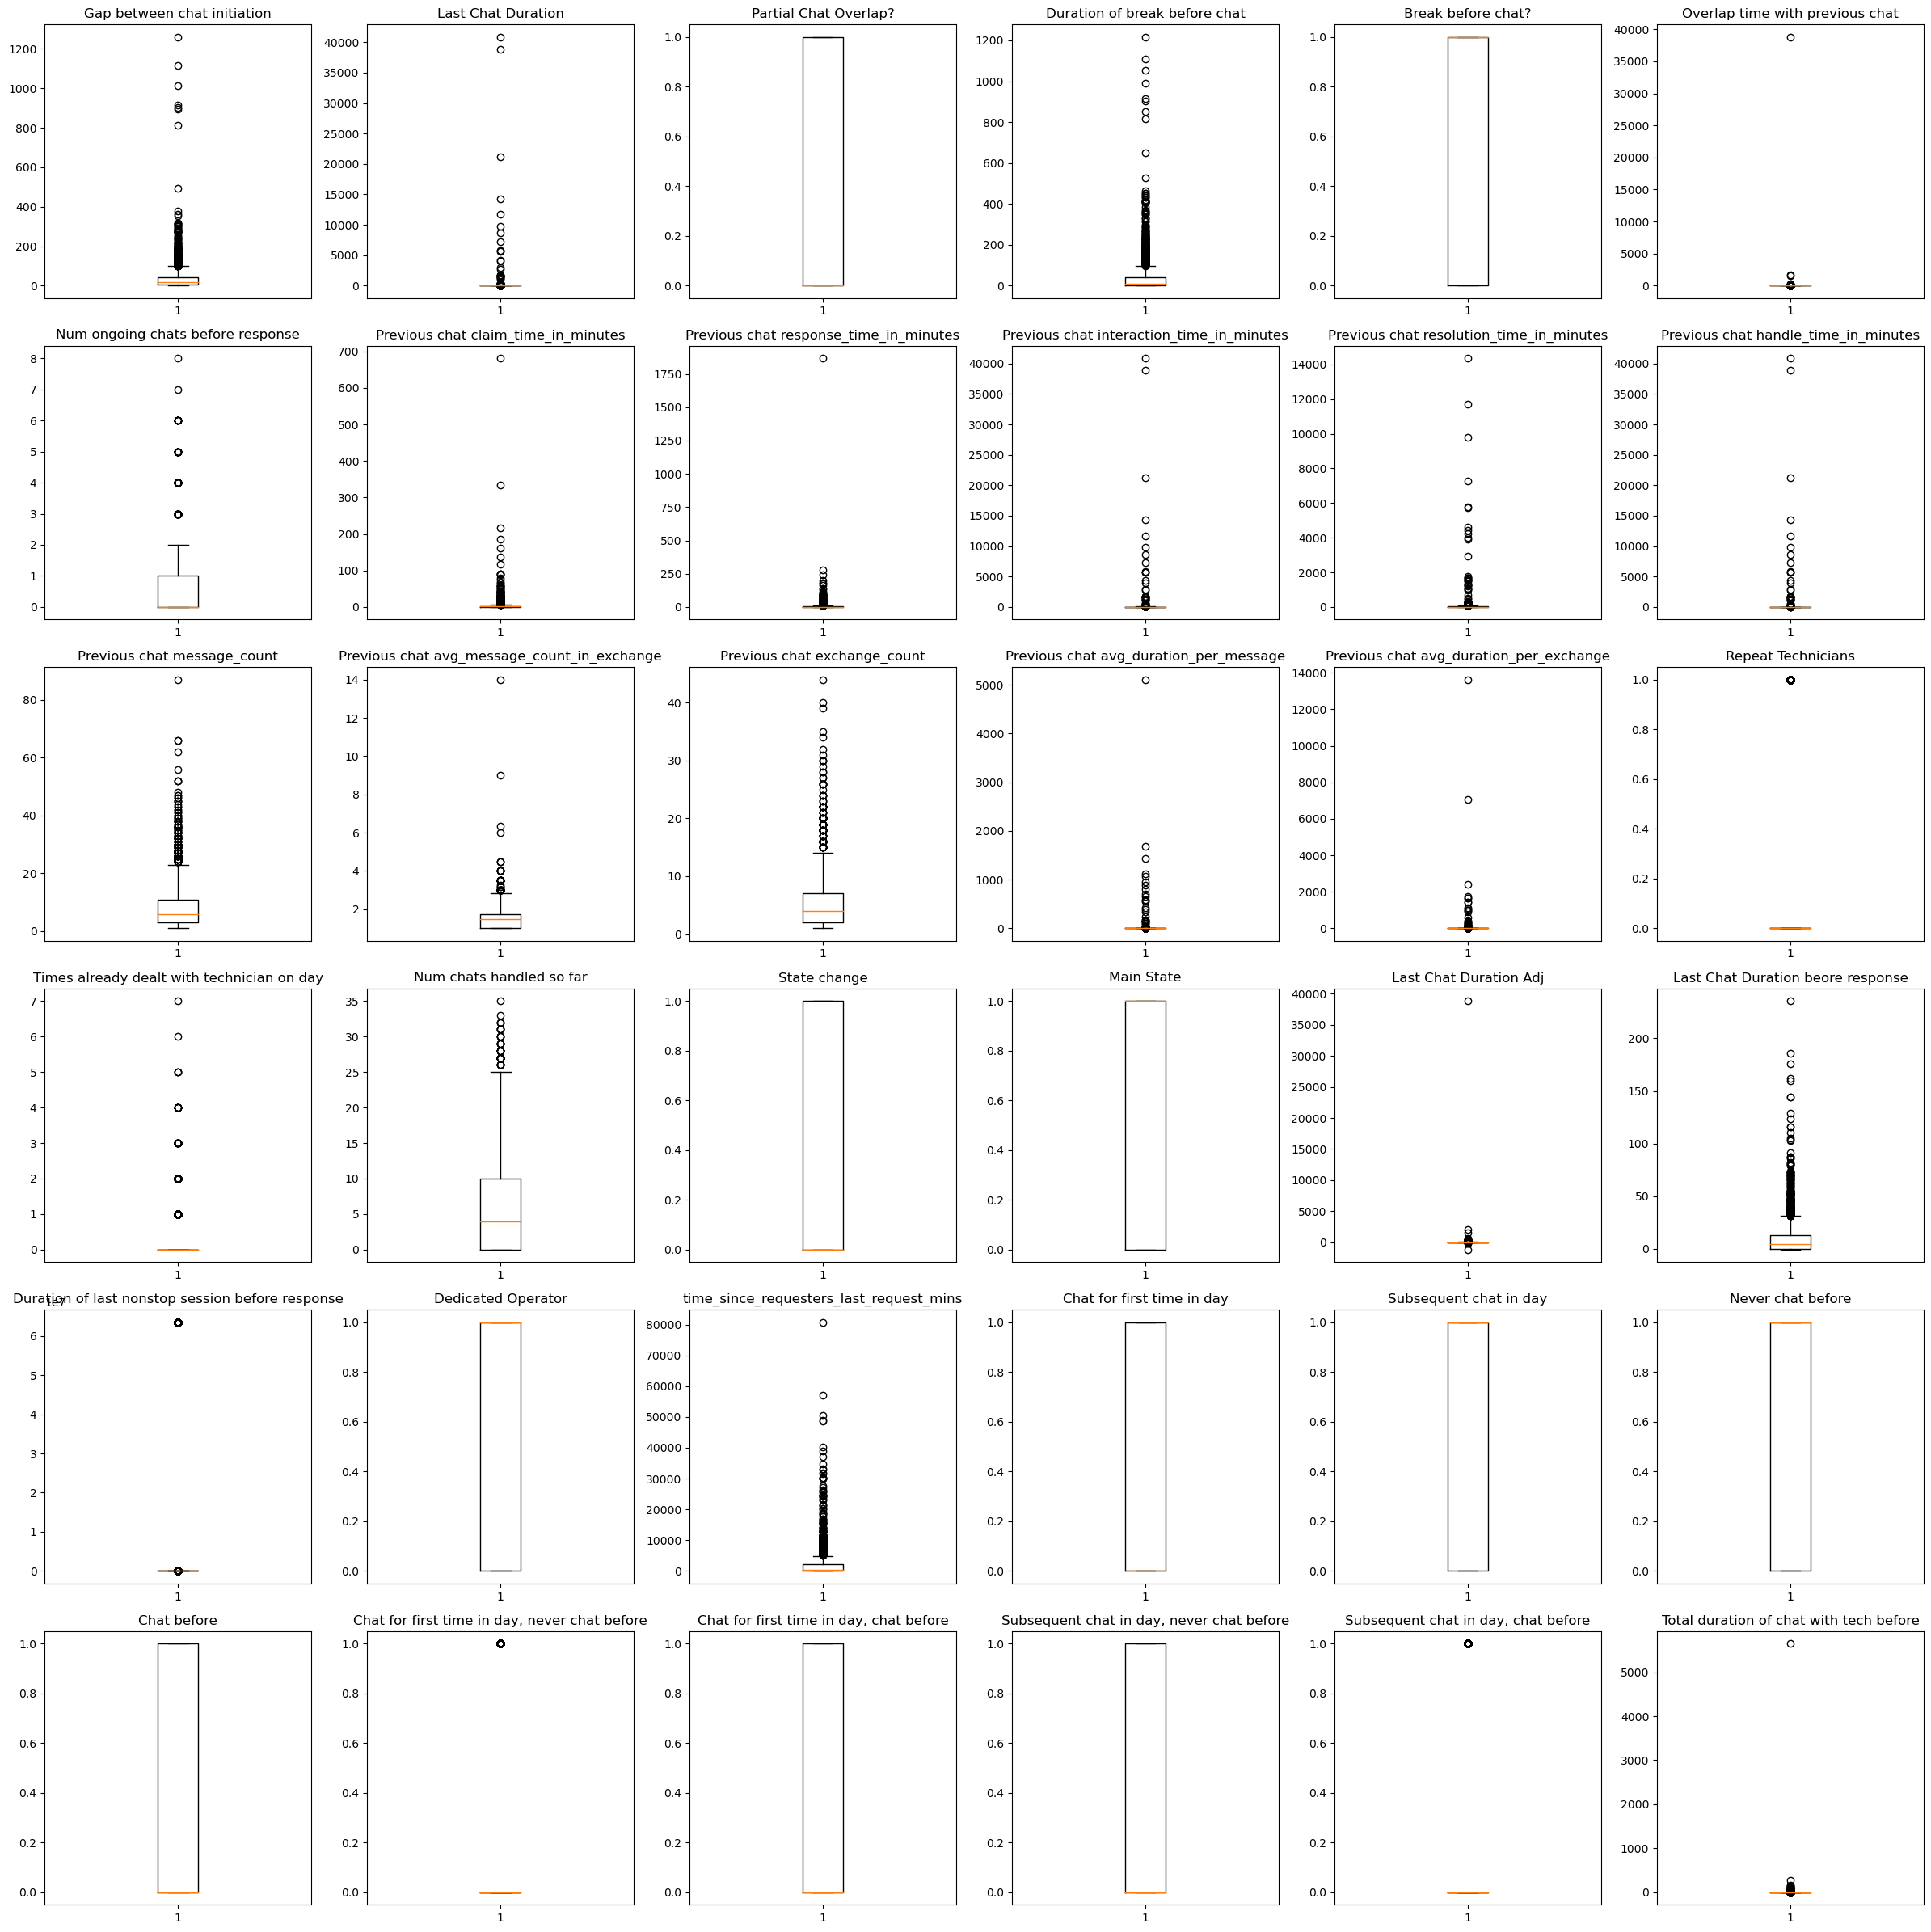

In [13]:
dataset = df[num_feature_cols]
f,a = plt.subplots(6,6, figsize=(24,24), dpi=100)
a = a.ravel()
for idx,ax in enumerate(a):
    ax.boxplot(dataset.iloc[:,idx])
    ax.set_title(dataset.columns[idx])
plt.subplots_adjust(top = 2.2, right=2)
plt.tight_layout()

In [14]:
# Defining outlier cols after EDA


outlier_cols = [ 'Previous chat claim_time_in_minutes',
       'Previous chat response_time_in_minutes',
       'Previous chat interaction_time_in_minutes',
       'Previous chat resolution_time_in_minutes',
       'Previous chat handle_time_in_minutes', 'Previous chat message_count',
       'Previous chat avg_message_count_in_exchange',
       'Previous chat exchange_count','Average of response_time_in_minutes'
               ]


### Data Cleansing - exclude A/H data, remove outliers from numerical features, select label to use (categorical vs continuous)

In [15]:
# Data cleansing

print(f'Original data shape - {df.shape}')

#remove pass 2 or above
df_upd = df[(df['Sum of SLA Pass']<=1)]
print(f'Excluding Unexpected Values for categorical label - {df_upd.shape}')

#Only Working Hours
hours_list = ['7 AM','8 AM','9 AM','10 AM','11 AM','12 PM','1 PM','2 PM','3 PM','4 PM','5 PM','6 PM']
df_upd = df_upd[df_upd['HOUR'].isin(hours_list)]
print(f'Excluding A/H work - {df_upd.shape}')

#Exclude 'outlier' technicians
df_upd = df_upd[df_upd['Outlier Technician (10)']==0]
print(f'Excluding Outlier Techs - {df_upd.shape}')

#Replace blank response times with claim times
df_upd['Average of response_time_in_minutes'] = df_upd['Average of response_time_in_minutes'].fillna(df_upd['Average of claim_time_in_minutes'])


#Replace blank resolution times with interaction times
df_upd['Average of resolution_time_in_minutes'] = df_upd['Average of resolution_time_in_minutes'].fillna(df_upd['Average of interaction_time_in_minutes'])


#Using 3 SD method for outlier removal
z = np.abs(stats.zscore(df_upd[outlier_cols]))
threshold = 3
#print(np.where(z>threshold))
#Print number of outliers
outl = np.sum(np.max(z,axis=1)>threshold)
print(f'Number of outliers - {outl}')

df_cleaned = df_upd[(z<threshold).all(axis=1)]
print(f'Excluding outliers in selected numerical cols - {df_cleaned.shape}')



'''
#Using Q1 - threshold*IQR, Q3 + threshold*IQR for outlier definition
threshold = 2
Q1 = df_upd[outlier_cols].quantile(0.25)
Q3 = df_upd[outlier_cols].quantile(0.75)
IQR = Q3 - Q1
print(f'-----Upper bounds----- \n{Q3+threshold*IQR}')

df_cleaned = df_upd[~((df_upd[outlier_cols] < (Q1 - threshold * IQR)) |(df_upd[outlier_cols] > (Q3 + threshold * IQR))).any(axis=1)]
print(f'Excluding outliers in selected numerical cols - {df_cleaned.shape}')
'''


#Identifying Numerical Features for Scaling in Next Step
df_num = df_cleaned[num_feature_cols]
print(f'Numerical features data - {df_num.shape}')

#Identifying Numerical Features for Scaling in Next Step
df_cat = df_cleaned[cat_feature_cols]
print(f'Categorical features data - {df_cat.shape}')

# Labels data [choose categorical or continuous]
df_label = df_cleaned['Sum of SLA Pass']
df_label_con = df_cleaned['Average of response_time_in_minutes']

print(f'Labels data - {df_label.shape}')


Original data shape - (2906, 70)
Excluding Unexpected Values for categorical label - (2906, 70)
Excluding A/H work - (2837, 70)
Excluding Outlier Techs - (1996, 70)
Number of outliers - 125
Excluding outliers in selected numerical cols - (1871, 70)
Numerical features data - (1871, 36)
Categorical features data - (1871, 5)
Labels data - (1871,)


In [16]:
#Checking for class imbalance
perc_label_1 = len(df_cleaned[df_cleaned['Sum of SLA Pass']==1])/len(df_cleaned)
print(f'{round(perc_label_1*100,1)} percent of labels are 1 - chat response time <3min')

70.4 percent of labels are 1 - chat response time <3min


In [17]:
# One hot encoding of categorical features, drop first to prevent multicollinearity
enc = preprocessing.OneHotEncoder()

df_cat.shape
df_cat_encoded = pd.get_dummies(df_cat,drop_first=True)
df_cat_encoded.head
df_cat_encoded.shape

(1871, 181)

In [18]:
# Appending one hot encoded categorical features back to numerical features
df_final = pd.concat([df_num,df_cat_encoded],axis=1)
df_final.shape

(1871, 217)

In [19]:
X = df_final
y = df_label
y_lin = df_label_con 

print(X.shape)
print(y.shape)
print(y_lin.shape)

(1871, 217)
(1871,)
(1871,)


In [20]:
#Output for Neural Net

#Due to their redundant architecture, neural networks, do not share a problem with multi-collienarity, 
#and are better able to predict in this situation (UPenn study).

data_nn = pd.concat([X,y],axis=1)
data_nn.to_csv('data\chat_data_nn.csv')

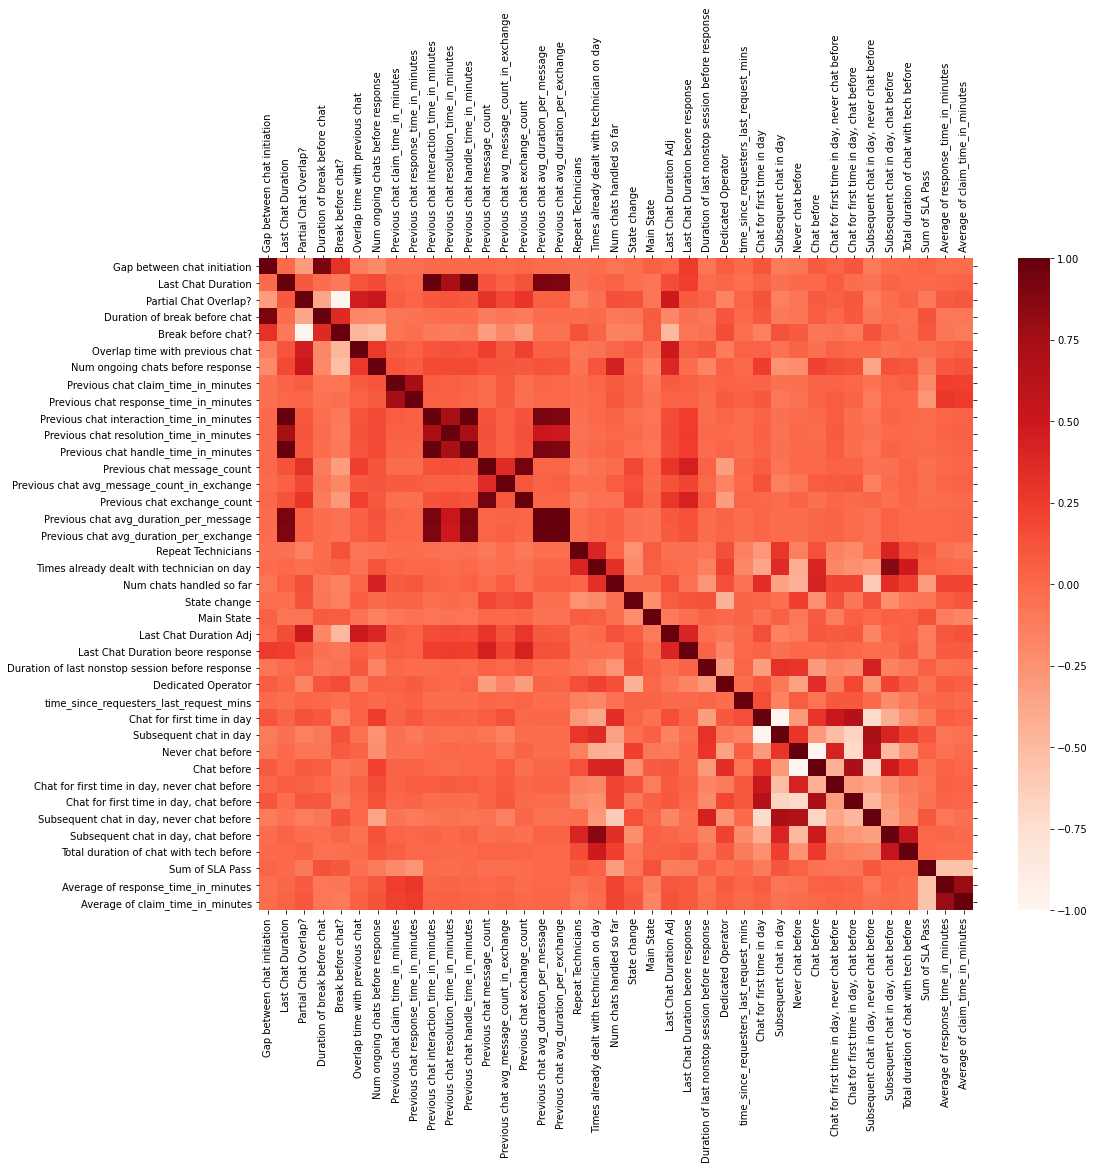

In [21]:
# See correlation between numerical features
plt.figure(figsize=(16,12))
cor = df_cleaned[num_feature_cols_label].corr()
ax = sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
ax.tick_params(right=True, top=True, labelright=False, labeltop=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.yticks(rotation=0)
plt.show()

In [22]:
#There is multi-collinearity - so remove variables based on variance inflation factor

def calculate_vif_(X, thresh=4.5):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    dropped_vars = []
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]
        #print(vif)
        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            dropped_vars.append(X[cols[variables]].columns[maxloc])
            variables = np.delete(variables, maxloc)
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[cols[variables]], dropped_vars

Remaining_X,dropped_vars = calculate_vif_(X)
Remaining_X = list(Remaining_X)

C:\Users\franz.iskandar\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


dropping 'Break before chat?' at index: 4
dropping 'Subsequent chat in day' at index: 27
dropping 'Dedicated Operator' at index: 24
dropping 'Chat for first time in day' at index: 25
dropping 'Never chat before' at index: 25
dropping 'Chat before' at index: 25
dropping 'Chat for first time in day, never chat before' at index: 25
dropping 'Subsequent chat in day, never chat before' at index: 26
dropping 'State_TAS' at index: 30
dropping 'State_VIC' at index: 30
dropping 'State_WA' at index: 30
dropping 'State_QLD' at index: 28
dropping 'Previous chat interaction_time_in_minutes' at index: 8
dropping 'Last Chat Duration' at index: 1
dropping 'Previous chat avg_duration_per_message' at index: 12
dropping 'State_SA' at index: 25
dropping 'Previous chat message_count' at index: 9
dropping 'Gap between chat initiation' at index: 0
dropping 'Previous chat handle_time_in_minutes' at index: 7
dropping 'Previous chat avg_message_count_in_exchange' at index: 7
dropping 'Subsequent chat in day, ch

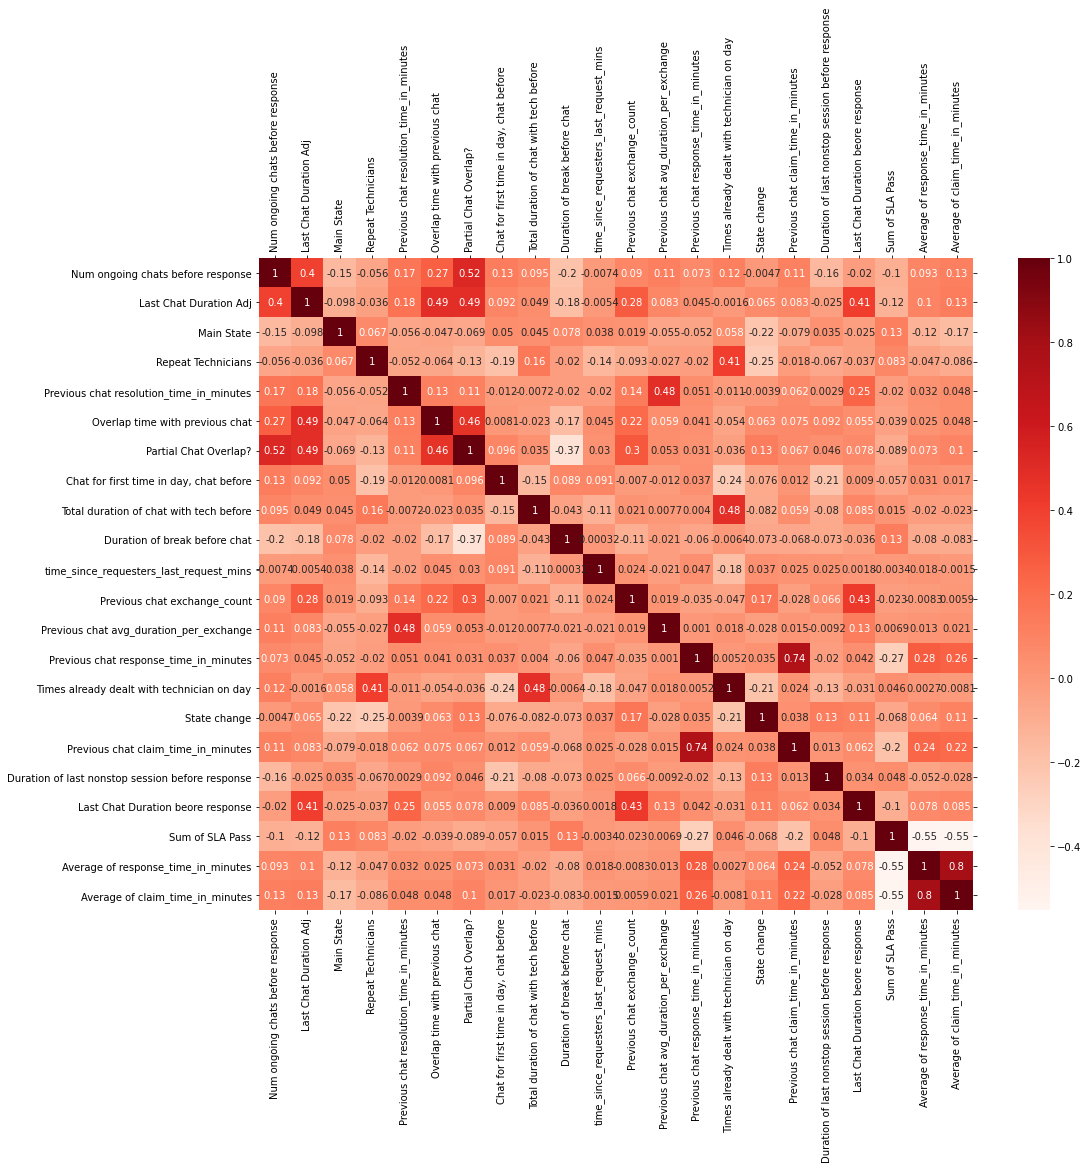

In [23]:
# See correlation between numerical features AFTER removal using VIF
lst1 = list(X[Remaining_X].columns)
lst2 = list(df_cleaned.columns)
num_cols_only = list(set(lst1) & set(lst2))
    

plt.figure(figsize=(16,12))
cor = df_cleaned[num_cols_only+label_cols].corr()
ax = sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
ax.tick_params(right=True, top=True, labelright=False, labeltop=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.yticks(rotation=0)
plt.show()

# Bi-variate & Multi-Variate Analysis

In [24]:
def create_scatter(x_plot,y_plot,hue,limit_range,threshold,s=30):
    plt.figure(figsize=(12,6))
    threshold = threshold
    
    if limit_range:
        x_Q1 = x_plot.quantile(0.25)
        x_Q3 = x_plot.quantile(0.75)
        x_IQR = x_Q3 - x_Q1
        y_Q1 = y_plot.quantile(0.25)
        y_Q3 = y_plot.quantile(0.75)
        y_IQR = y_Q3 - y_Q1

        x_plot = x_plot[~((x_plot < (x_Q1 - threshold * x_IQR)) |(x_plot > (x_Q3 + threshold * x_IQR)))]
        y_plot = y_plot[~((y_plot < (x_Q1 - threshold * y_IQR)) |(y_plot > (y_Q3 + threshold * y_IQR)))]
    
    sns.scatterplot(x_plot, y_plot, hue=hue,s=s)
    plt.xlabel(x_plot.name)
    plt.ylabel(y_plot.name)

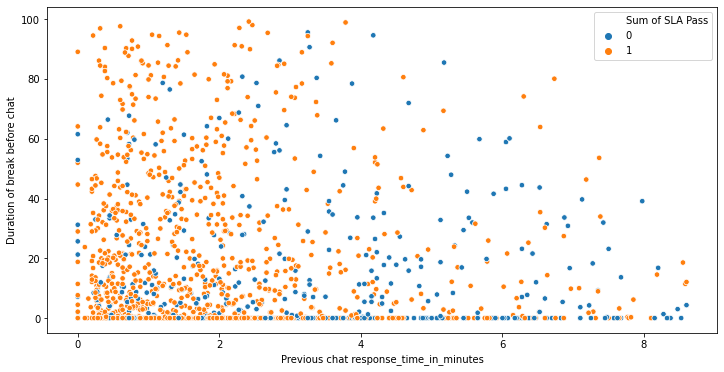

In [25]:
x_plot = df_cleaned['Previous chat response_time_in_minutes']
y_plot = df_cleaned['Duration of break before chat']
hue = df_cleaned['Sum of SLA Pass']
create_scatter(x_plot,y_plot,hue,limit_range=True,threshold=1.5)

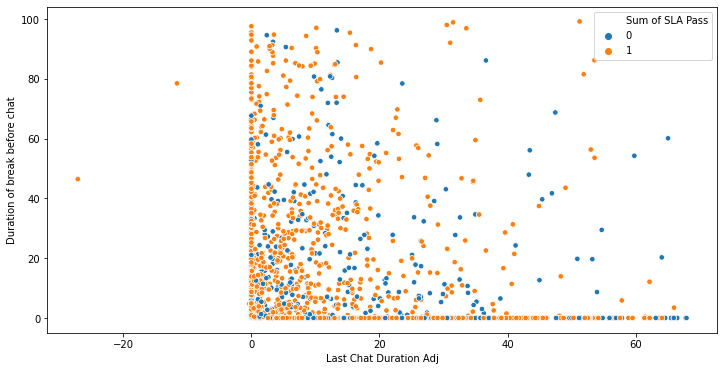

In [26]:
x_plot = df_num['Last Chat Duration Adj']
y_plot = df_cleaned['Duration of break before chat']
hue = df_cleaned['Sum of SLA Pass']
create_scatter(x_plot,y_plot,hue,limit_range=True,threshold=1.5)

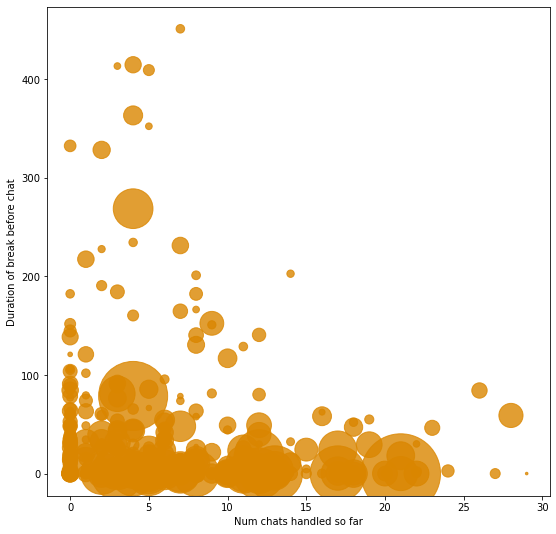

In [27]:
# Bubble plot - size is response time in minutes
df_sample = df_cleaned.sample(n=400,random_state=1)
x_plot = df_sample['Num chats handled so far']
y_plot = df_sample['Duration of break before chat']
s = df_sample['Average of response_time_in_minutes']
fig, ax = plt.subplots()
fig.set_size_inches(9, 9)
sns.regplot(
    x_plot,y_plot , fit_reg = False, color = '#da8600', scatter_kws={'s':s*100}, ax=ax
)

In [28]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,round(y[i],2),round(y[i],2),ha='center')

In [29]:
def plot_bar(x_plot,y_plot,ticks,labels):
    dfg = y_plot.groupby(x_plot).mean()
    plt.bar(dfg.index,dfg,color='maroon',width=0.5)
    plt.xticks(ticks=ticks,labels=labels)
    plt.title(x_plot.name)
    addlabels(ticks, dfg)  

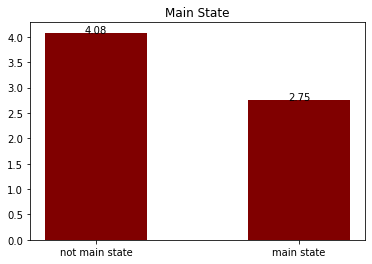

In [30]:
x_plot = df_cleaned['Main State']    
y_plot = df_cleaned['Average of response_time_in_minutes']
ticks=[0,1]
labels = ['not main state','main state']
plot_bar(x_plot,y_plot,ticks,labels)  

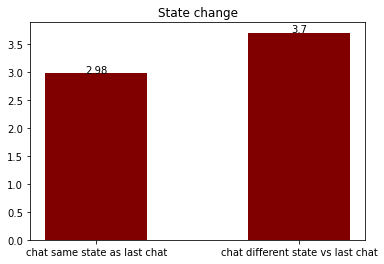

In [31]:
x_plot = df_cleaned['State change']    
y_plot = df_cleaned['Average of response_time_in_minutes']   
ticks=[0,1]
labels = ['chat same state as last chat','chat different state vs last chat']
plot_bar(x_plot,y_plot,ticks,labels) 

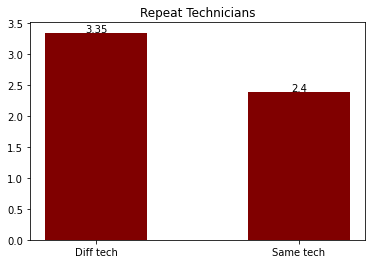

In [32]:
x_plot = df_cleaned['Repeat Technicians']    
y_plot = df_cleaned['Average of response_time_in_minutes']   
ticks=[0,1]
labels = ['Diff tech','Same tech']
plot_bar(x_plot,y_plot,ticks,labels) 

# Train Test Split, Scaling, and Models

In [33]:
#CLASS IMBALANCE FOR CATEGORICAL LABEL
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

rus = RandomOverSampler(random_state=0)
#rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_sample(X, y)

print(len(X_resampled))
print(len(X))
print(len(y_resampled[y_resampled==0]==0))
print(len(y[y==0]==0))

#X = X_resampled
#y = y_resampled

2634
1871
1317
554


In [34]:
# Split dataset into training set and test set
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X[Remaining_X], y, test_size=0.3, random_state=1) # 70% training and 30% test


In [35]:
from sklearn.preprocessing import StandardScaler

#Scaling across all variables
scaling = StandardScaler().fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)


'''
#Scaling only num_cols
scaling = StandardScaler().fit(X_train[num_cols_only])
X_train[num_cols_only] = scaling.transform(X_train[num_cols_only])
X_test[num_cols_only] = scaling.transform(X_test[num_cols_only])
'''
print(X_train.shape)
print(X_test.shape)

(1309, 195)
(562, 195)


# SVM Classifier

In [36]:
# First view of SVM Classifier - just checking
from sklearn.svm import LinearSVC, SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = svclassifier.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Out of all the classes, how much predicted correctly

Accuracy: 0.800711743772242


In [37]:
# First view of SVM Classifier with RBF - just checking
from sklearn.svm import LinearSVC, SVC
svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = svclassifier.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Out of all the classes, how much predicted correctly

Accuracy: 0.7188612099644128


In [38]:
param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
#Adding all values of hyperparameters in a list from which the values of hyperparameter will randomly inserted as hyperparameter
svclassifier = SVC(kernel='linear')
rnd_search_cv = RandomizedSearchCV(svclassifier, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train[:1000], y_train[:1000])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=7.991652944406509, gamma=0.007241879604234958 .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .. C=7.991652944406509, gamma=0.007241879604234958, total=   1.3s
[CV] C=7.991652944406509, gamma=0.007241879604234958 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] .. C=7.991652944406509, gamma=0.007241879604234958, total=   2.0s
[CV] C=7.991652944406509, gamma=0.007241879604234958 .................
[CV] .. C=7.991652944406509, gamma=0.007241879604234958, total=   1.6s
[CV] C=8.565998012614745, gamma=0.0010406407192580772 ................
[CV] . C=8.565998012614745, gamma=0.0010406407192580772, total=   1.7s
[CV] C=8.565998012614745, gamma=0.0010406407192580772 ................
[CV] . C=8.565998012614745, gamma=0.0010406407192580772, total=   2.5s
[CV] C=8.565998012614745, gamma=0.0010406407192580772 ................
[CV] . C=8.565998012614745, gamma=0.0010406407192580772, total=   3.0s
[CV] C=9.5208730842151, gamma=0.0034409855240135055 ..................
[CV] ... C=9.5208730842151, gamma=0.0034409855240135055, total=   1.8s
[CV] C=9.5208730842151, gamma=0.0034409855240135055 ..................
[CV] ... C=9.5208730842151, gamma=0.0034409855240135055, total=   1.7s
[CV] C=9.5208730842151, gamma=0.0034409855240135055 ..................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   53.2s finished


RandomizedSearchCV(cv=3, estimator=SVC(kernel='linear'),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002C28C733A90>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002C28DDBE7F0>},
                   verbose=2)

In [39]:
rnd_search_cv.best_estimator_

SVC(C=9.5208730842151, gamma=0.0034409855240135055, kernel='linear')

In [40]:
# Using SVM with optimal hyperparameters
svc_opt = rnd_search_cv.best_estimator_

svc_opt.fit(X_train, y_train)
y_pred = svc_opt.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8096085409252669


Confusion matrix:
 [[ 87  79]
 [ 28 368]]


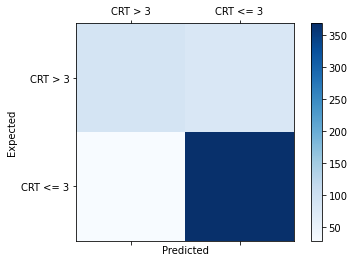

              precision    recall  f1-score   support

           0       0.76      0.52      0.62       166
           1       0.82      0.93      0.87       396

    accuracy                           0.81       562
   macro avg       0.79      0.73      0.75       562
weighted avg       0.80      0.81      0.80       562



In [41]:
# Confusion Matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['CRT > 3', 'CRT <= 3']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()
print(classification_report(y_test,y_pred))

# Recall (TP/TP+FN) - Out of all the positive classes, how much we predicted correctly
# Precision (TP/TP+FP) - Out of all the positive classes we have predicted correctly, how many are actually positive
# F1 score - measure Recall and Precision at the same time using Harmonic Mean vs Arithmetic Mean

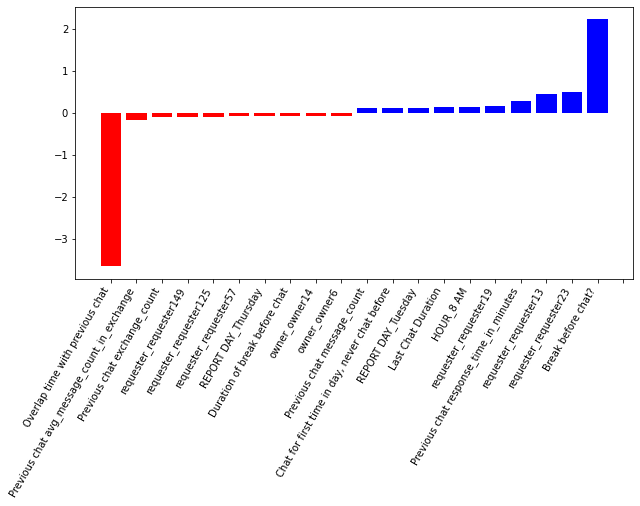

In [42]:
def plot_coefficients(classifier, feature_names, top_features=10):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(10, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

plot_coefficients(svc_opt,list(X.columns))

In [43]:
# def f_importances(coef, names, top=-1):
#     imp = coef
#     imp, names = zip(*sorted(list(zip(imp, names))))

#     # Show all features
#     if top == -1:
#         top = len(names)

#     plt.barh(range(top), imp[::-1][0:top], align='center')
#     plt.yticks(range(top), names[::-1][0:top])
#     plt.show()
#     #print(imp)
#     #print(names)
#     print(list(zip(names, imp)))

# feature_names = list(X.columns) 
    
# f_importances(abs(svc_opt.coef_[0]), feature_names, top=3)


# Decision Tree

In [44]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(max_depth = 4, 
                             random_state = 0,criterion = 'gini')

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

clf.score(X_test,y_test)

Accuracy: 0.7686832740213523


0.7686832740213523

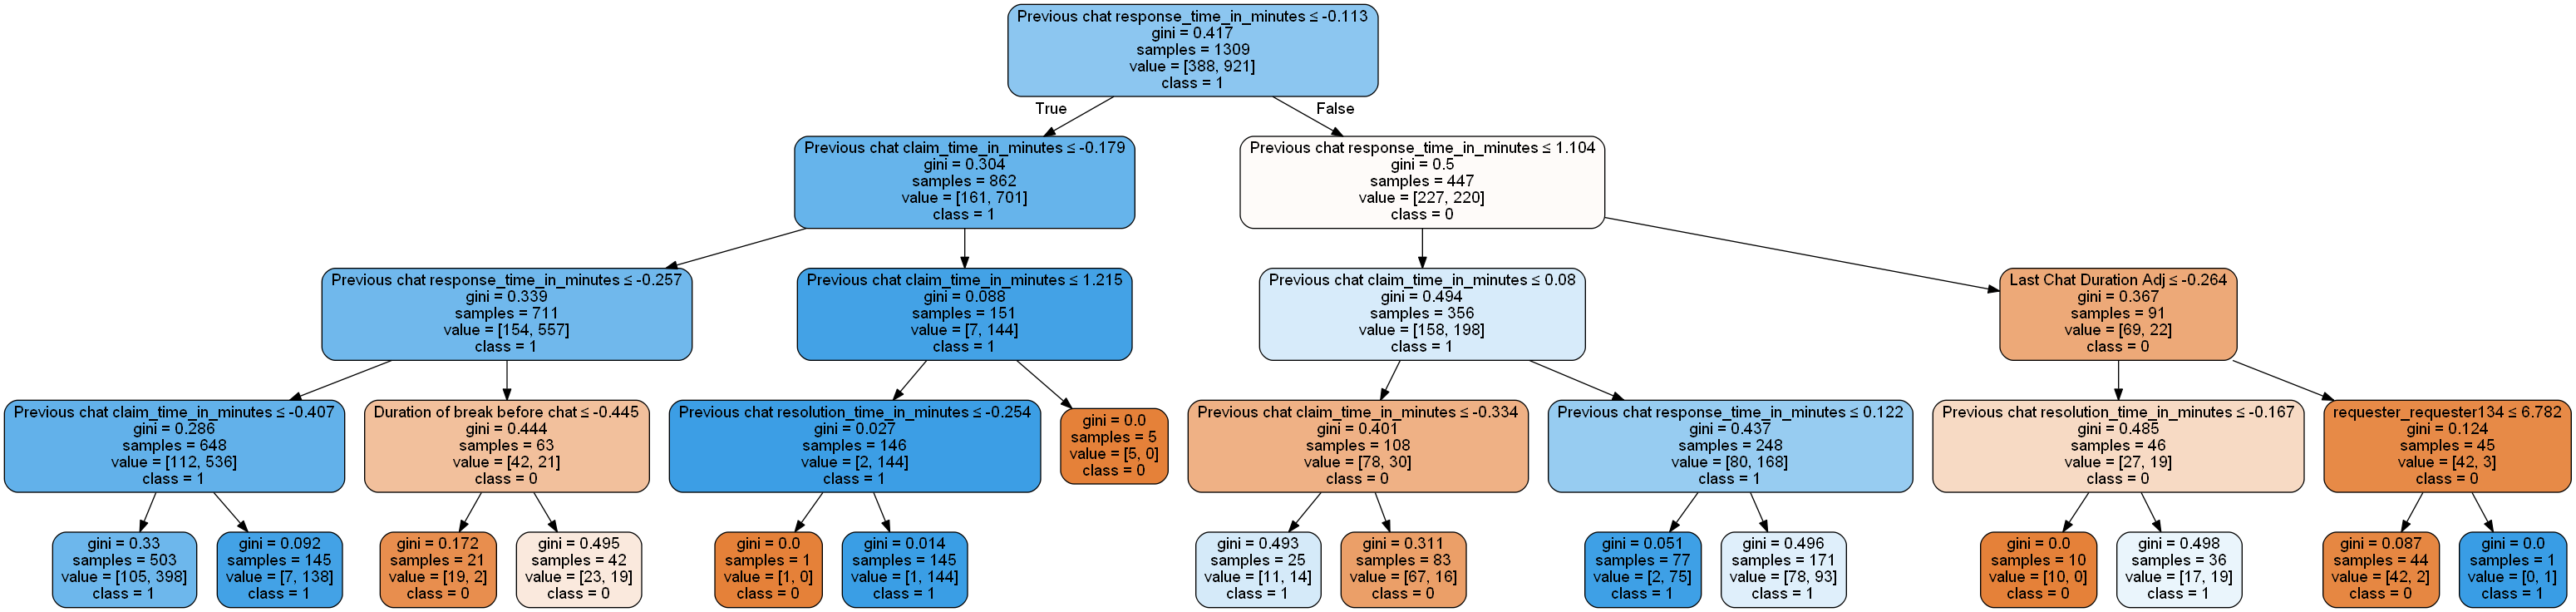

In [45]:
#feature_cols = num_feature_cols + list(df_cat_encoded.columns)
feature_cols = Remaining_X

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('decisiontree.png')
Image(graph.create_png())

In [46]:
param_distributions = {"max_depth": uniform(1, 30)}
#Adding all values of hyperparameters in a list from which the values of hyperparameter will randomly inserted as hyperparameter
classifier = DecisionTreeClassifier(random_state=0,criterion = 'gini')
rnd_search_cv = RandomizedSearchCV(classifier, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train[:1000], y_train[:1000])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] max_depth=14.591190797997108 ....................................
[CV] ..................... max_depth=14.591190797997108, total=   0.0s
[CV] max_depth=14.591190797997108 ....................................
[CV] ..................... max_depth=14.591190797997108, total=   0.0s
[CV] max_depth=14.591190797997108 ....................................
[CV] ..................... max_depth=14.591190797997108, total=   0.0s
[CV] max_depth=23.301249728325928 ....................................
[CV] ..................... max_depth=23.301249728325928, total=   0.0s
[CV] max_depth=23.301249728325928 ....................................
[CV] ..................... max_depth=23.301249728325928, total=   0.0s
[CV] max_depth=23.301249728325928 ....................................
[CV] ..................... max_depth=23.301249728325928, total=   0.0s
[CV] max_depth=28.240972771480077 ....................................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] max_depth=28.6443691655552 ......................................
[CV] ....................... max_depth=28.6443691655552, total=   0.0s
[CV] max_depth=28.6443691655552 ......................................
[CV] ....................... max_depth=28.6443691655552, total=   0.0s
[CV] max_depth=28.6443691655552 ......................................
[CV] ....................... max_depth=28.6443691655552, total=   0.0s
[CV] max_depth=15.174327095550726 ....................................
[CV] ..................... max_depth=15.174327095550726, total=   0.0s
[CV] max_depth=15.174327095550726 ....................................
[CV] ..................... max_depth=15.174327095550726, total=   0.0s
[CV] max_depth=15.174327095550726 ....................................
[CV] ..................... max_depth=15.174327095550726, total=   0.0s
[CV] max_depth=13.624148337917585 ....................................
[CV] ..................... max_depth=13.624148337917585, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.5s finished


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=0),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002C28C38FD30>},
                   verbose=2)

In [47]:
rnd_search_cv.best_estimator_

DecisionTreeClassifier(max_depth=17.17145783038284, random_state=0)

In [48]:
# Using Decision Tree with optimal depth
dtc_opt = rnd_search_cv.best_estimator_

dtc_opt.fit(X_train, y_train)
y_pred = dtc_opt.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7793594306049823


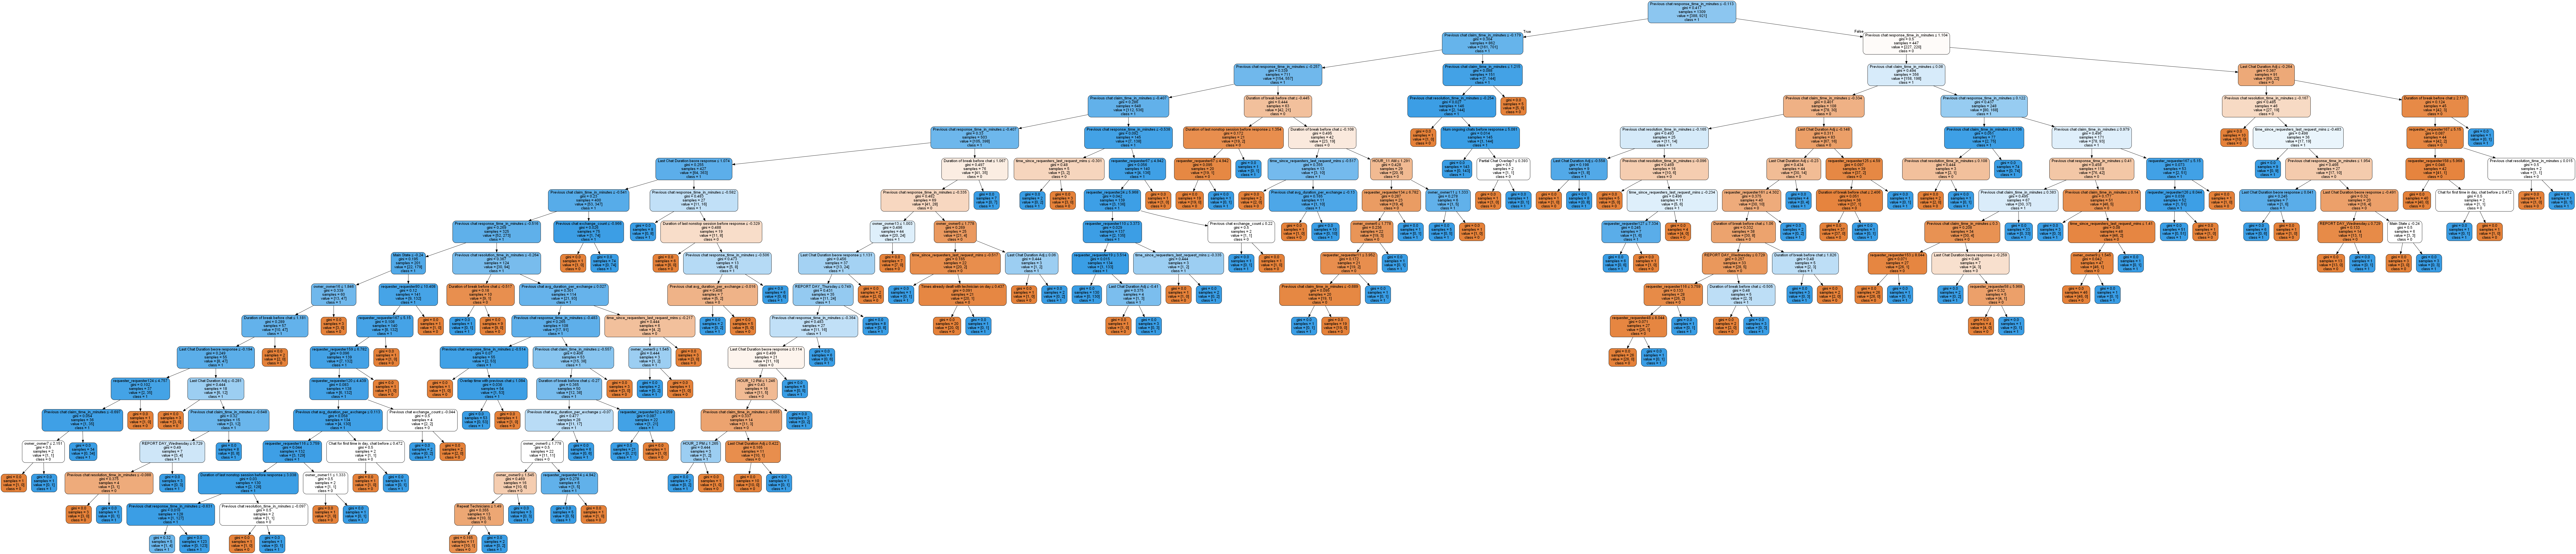

In [49]:
feature_cols = Remaining_X

dot_data = StringIO()
export_graphviz(dtc_opt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('decisiontree.png')
Image(graph.create_png())

# Random Forest

In [50]:
# Testing out random forest
from sklearn.ensemble import RandomForestClassifier
# Create RF classifer object
clf_rf = RandomForestClassifier(max_depth=12, n_estimators=20, max_features=2)

# Train RF Classifer
clf_rf = clf_rf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf_rf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7046263345195729


In [51]:
param_distributions = {"max_depth": np.arange(1, 31),"n_estimators": np.arange(1,51), "max_features":np.arange(0.1,1.05,0.05)}
#Adding all values of hyperparameters in a list from which the values of hyperparameter will randomly inserted as hyperparameter
classifier = RandomForestClassifier(random_state=0)
rnd_search_cv = RandomizedSearchCV(classifier, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train[:1000], y_train[:1000])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=17, max_features=0.25000000000000006, max_depth=22 .
[CV]  n_estimators=17, max_features=0.25000000000000006, max_depth=22, total=   0.1s
[CV] n_estimators=17, max_features=0.25000000000000006, max_depth=22 .
[CV]  n_estimators=17, max_features=0.25000000000000006, max_depth=22, total=   0.1s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] n_estimators=17, max_features=0.25000000000000006, max_depth=22 .
[CV]  n_estimators=17, max_features=0.25000000000000006, max_depth=22, total=   0.1s
[CV] n_estimators=3, max_features=0.30000000000000004, max_depth=29 ..
[CV]  n_estimators=3, max_features=0.30000000000000004, max_depth=29, total=   0.0s
[CV] n_estimators=3, max_features=0.30000000000000004, max_depth=29 ..
[CV]  n_estimators=3, max_features=0.30000000000000004, max_depth=29, total=   0.0s
[CV] n_estimators=3, max_features=0.30000000000000004, max_depth=29 ..
[CV]  n_estimators=3, max_features=0.30000000000000004, max_depth=29, total=   0.0s
[CV] n_estimators=12, max_features=0.3500000000000001, max_depth=24 ..
[CV]  n_estimators=12, max_features=0.3500000000000001, max_depth=24, total=   0.1s
[CV] n_estimators=12, max_features=0.3500000000000001, max_depth=24 ..
[CV]  n_estimators=12, max_features=0.3500000000000001, max_depth=24, total=   0.1s
[CV] n_estimators=12, max_features=0.3500000000000001, max_depth=24 

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    2.9s finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
                   param_distributions={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
                                        'max_features': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                                        'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
                   verbose=2)

In [52]:
rnd_search_cv.best_estimator_

RandomForestClassifier(max_depth=29, max_features=0.45000000000000007,
                       n_estimators=31, random_state=0)

In [53]:
# Using random forest with optimal hyperparameters
rf_opt = rnd_search_cv.best_estimator_

rf_opt.fit(X_train, y_train)
y_pred = rf_opt.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8238434163701067


In [54]:
# Finding the top features, for which the accuracy is the highest

#no of features
nof_list=np.arange(1,30)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    #model = LogisticRegression()
    model = rf_opt
    rfe = RFE(model,n_features_to_select=nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Top features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Top features: 2
Score with 2 features: 0.848754


In [55]:
rfe = RFE(rf_opt, nof)
rfe = rfe.fit(X_train, y_train.values.ravel())
#print(rfe.support_)
#print(rfe.ranking_)
print ("Features sorted by their rank:")
#print (sorted(zip(map(lambda x: round(x, 2), rfe.ranking_), Remaining_X)))

print(sorted(zip(rfe.ranking_,Remaining_X))[:10])


cols = Remaining_X

temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
rfe_features = list(selected_features_rfe)
print ('Top features - optimal:')
print(selected_features_rfe)

C:\Users\franz.iskandar\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Features sorted by their rank:
[(1, 'Previous chat claim_time_in_minutes'), (1, 'Previous chat response_time_in_minutes'), (2, 'Last Chat Duration Adj'), (3, 'Previous chat resolution_time_in_minutes'), (4, 'time_since_requesters_last_request_mins'), (5, 'Duration of break before chat'), (6, 'Last Chat Duration beore response'), (7, 'Previous chat avg_duration_per_exchange'), (8, 'Duration of last nonstop session before response'), (9, 'Previous chat exchange_count')]
Top features - optimal:
Index(['Previous chat claim_time_in_minutes', 'Previous chat response_time_in_minutes'], dtype='object')


# Logistic Regression

In [56]:
# Finding the top features, for which the accuracy is the highest

#no of features
nof_list=np.arange(1,len(X[Remaining_X].columns))            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    model = LogisticRegression()
    rfe = RFE(model,n_features_to_select=nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Top features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Top features: 10
Score with 10 features: 0.791815


In [57]:
#RFE

logreg = LogisticRegression()
rfe = RFE(logreg, nof)
rfe = rfe.fit(X[Remaining_X], y.values.ravel())
#print(rfe.support_)
#print(rfe.ranking_)
print ("Features sorted by their rank:")
#print (sorted(zip(map(lambda x: round(x, 2), rfe.ranking_), Remaining_X)))

print(sorted(zip(rfe.ranking_,Remaining_X))[:10])


cols = list(X[Remaining_X].columns)

temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
rfe_features = list(selected_features_rfe)
print ('Top features - optimal:')
print(selected_features_rfe)

C:\Users\franz.iskandar\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Features sorted by their rank:
[(1, 'Duration of break before chat'), (1, 'Last Chat Duration Adj'), (1, 'Last Chat Duration beore response'), (1, 'Main State'), (1, 'Overlap time with previous chat'), (1, 'Previous chat avg_duration_per_exchange'), (1, 'Previous chat claim_time_in_minutes'), (1, 'Previous chat exchange_count'), (1, 'Previous chat response_time_in_minutes'), (1, 'Total duration of chat with tech before')]
Top features - optimal:
Index(['Duration of break before chat', 'Overlap time with previous chat',
       'Previous chat claim_time_in_minutes',
       'Previous chat response_time_in_minutes',
       'Previous chat exchange_count',
       'Previous chat avg_duration_per_exchange', 'Main State',
       'Last Chat Duration Adj', 'Last Chat Duration beore response',
       'Total duration of chat with tech before'],
      dtype='object')


C:\Users\franz.iskandar\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\franz.iskandar\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

In [58]:
#RFE
#Model is over-specified, and exhausted degrees of freedom - rule of thumb is 20 observations per variable
# Sample size is about 1.8K, so 90 features

logreg = LogisticRegression()
rfe = RFE(logreg, 90)
rfe = rfe.fit(X[Remaining_X], y.values.ravel())
#print(rfe.support_)
#print(rfe.ranking_)
print ("Features sorted by their rank:")
#print (sorted(zip(map(lambda x: round(x, 2), rfe.ranking_), Remaining_X)))

print(sorted(zip(rfe.ranking_,Remaining_X))[:10])


cols = list(X[Remaining_X].columns)

temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
rfe_features = list(selected_features_rfe)
print ('Top features - optimal:')
print(selected_features_rfe)

C:\Users\franz.iskandar\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=90 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Features sorted by their rank:
[(1, 'Chat for first time in day, chat before'), (1, 'Duration of break before chat'), (1, 'Duration of last nonstop session before response'), (1, 'HOUR_10 AM'), (1, 'HOUR_11 AM'), (1, 'HOUR_12 PM'), (1, 'HOUR_2 PM'), (1, 'HOUR_3 PM'), (1, 'HOUR_4 PM'), (1, 'HOUR_5 PM')]
Top features - optimal:
Index(['Partial Chat Overlap?', 'Duration of break before chat',
       'Overlap time with previous chat', 'Num ongoing chats before response',
       'Previous chat claim_time_in_minutes',
       'Previous chat response_time_in_minutes',
       'Previous chat resolution_time_in_minutes',
       'Previous chat exchange_count',
       'Previous chat avg_duration_per_exchange', 'Repeat Technicians',
       'Times already dealt with technician on day', 'State change',
       'Main State', 'Last Chat Duration Adj',
       'Last Chat Duration beore response',
       'Duration of last nonstop session before response',
       'time_since_requesters_last_request_mins',
  

In [59]:
import statsmodels.api as sm

#If building a model for prediction, then split the data to avoid the over-fitting 
#If just to study and analyse the data then it is not required to split the data.

#X_logit = df_final[num_feature_cols]
#X_logit = pd.concat([df_final[num_feature_cols],df_final[cat_cols]],axis=1)
X_logit = X[selected_features_rfe]

logit_model=sm.Logit(y,sm.add_constant(X_logit))
result=logit_model.fit()
print(result.summary())

         Current function value: 0.502178
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:        Sum of SLA Pass   No. Observations:                 1871
Model:                          Logit   Df Residuals:                     1780
Method:                           MLE   Df Model:                           90
Date:                Tue, 06 Jul 2021   Pseudo R-squ.:                  0.1734
Time:                        10:24:08   Log-Likelihood:                -939.57
converged:                      False   LL-Null:                       -1136.7
Covariance Type:            nonrobust   LLR p-value:                 1.126e-39
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                                0.0944      0.3

C:\Users\franz.iskandar\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [60]:
# Accuracy
y_logit_pred = result.predict(sm.add_constant(X_logit))
prediction = list(map(round, y_logit_pred))

# accuracy score of the model
print('Test accuracy = ', accuracy_score(y, prediction))

Test accuracy =  0.7915553180117584


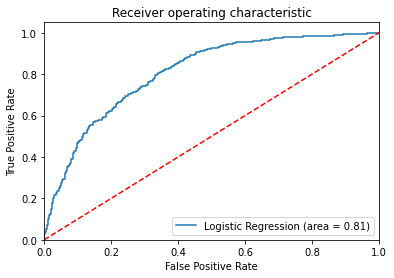

In [61]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y, y_logit_pred)
fpr, tpr, thresholds = roc_curve(y, y_logit_pred)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Confusion matrix:
 [[ 224  330]
 [  60 1257]]


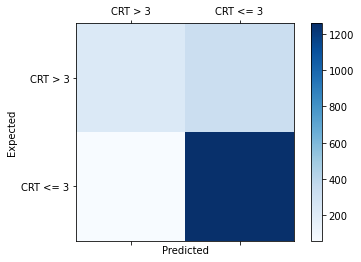

              precision    recall  f1-score   support

           0       0.79      0.40      0.53       554
           1       0.79      0.95      0.87      1317

    accuracy                           0.79      1871
   macro avg       0.79      0.68      0.70      1871
weighted avg       0.79      0.79      0.77      1871



In [62]:
# Confusion Matrix

conf_mat_logr = confusion_matrix(y_true=y, y_pred=prediction)
print('Confusion matrix:\n', conf_mat_logr)

labels = ['CRT > 3', 'CRT <= 3']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat_logr, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()
print(classification_report(y,prediction))

# Linear Regression

In [63]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression().fit(X[Remaining_X], y_lin)
y_lin_pred= linreg.predict(X[Remaining_X])
print('R2 of linear regression classifier on test set: {:.3f}'.format(linreg.score(X[Remaining_X], y_lin)))

R2 of linear regression classifier on test set: 0.235


In [64]:
print('Mean Absolute Error:', mean_absolute_error(y, y_lin_pred)) 
print('Mean Squared Error:', mean_squared_error(y, y_lin_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, y_lin_pred)))

Mean Absolute Error: 2.7539873615215673
Mean Squared Error: 14.822951638834509
Root Mean Squared Error: 3.850058653947302


In [65]:
#Linear Regression
X_lin = sm.add_constant(X[Remaining_X]) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y_lin, X_lin).fit() ## sm.OLS(output, input)
predictions = model.predict(X_lin)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                    
===============================================================================================
Dep. Variable:     Average of response_time_in_minutes   R-squared:                       0.235
Model:                                             OLS   Adj. R-squared:                  0.146
Method:                                  Least Squares   F-statistic:                     2.636
Date:                                 Tue, 06 Jul 2021   Prob (F-statistic):           3.72e-25
Time:                                         10:24:10   Log-Likelihood:                -5602.7
No. Observations:                                 1871   AIC:                         1.160e+04
Df Residuals:                                     1675   BIC:                         1.268e+04
Df Model:                                          195                                         
Covariance Type:                             nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                                4.2251      1.539      2.746      0.006       1.207       7.243
Partial Chat Overlap?                               -0.0540      0.386     -0.140      0.889      -0.812       0.704
Duration of break before chat                       -0.0053      0.002     -2.390      0.017      -0.010      -0.001
Overlap time with previous chat                     -0.0161      0.010     -1.592      0.112      -0.036       0.004
Num ongoing chats before response                    0.3088      0.173      1.790      0.074      -0.030       0.647
Previous chat claim_time_in_minutes                  0.1086      0.057      1.914      0.056      -0.003       0.220
Previous chat response_time_in_minutes               0.1432      0.031      4.632      0.000       0.083       0.204
Previous chat resolution_time_in_minutes          4.933e-05      0.001      0.037      0.970      -0.003       0.003
Previous chat exchange_count                        -0.0481      0.038     -1.252      0.211      -0.124       0.027
Previous chat avg_duration_per_exchange          -5.433e-05      0.006     -0.010      0.992      -0.011       0.011
Repeat Technicians                                  -0.7239      0.515     -1.406      0.160      -1.734       0.286
Times already dealt with technician on day           0.1994      0.306      0.652      0.515      -0.401       0.800
State change                                         0.6331      0.317      1.998      0.046       0.012       1.255
Main State                                          -0.9919      0.321     -3.094      0.002      -1.621      -0.363
Last Chat Duration Adj                               0.0098      0.004      2.254      0.024       0.001       0.018
Last Chat Duration beore response                    0.0126      0.011      1.204      0.229      -0.008       0.033
Duration of last nonstop session before response -9.079e-09   7.71e-09     -1.177      0.239   -2.42e-08    6.04e-09
time_since_requesters_last_request_mins          -1.027e-05   2.68e-05     -0.383      0.702   -6.28e-05    4.23e-05
Chat for first time in day, chat before             -0.2463      0.373     -0.660      0.510      -0.979       0.486
Total duration of chat with tech before             -0.0348      0.013     -2.601      0.009      -0.061      -0.009
REPORT DAY_Monday                                    0.6660      0.404      1.647      0.100      -0.127       1.459
REPORT DAY_Thursday                                  0.0348      0.409      0.085      0